```
Topic:        Project 2
Subject:      Predicting Premier League Players' Salaries
Date:         07/17/2020
Name:         David Weon

Notebook has been cleaned using nbextension 'Code prettify'
```

# Linear Regression on Premier League Players' Salaries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data Clean and Check

## Data Clean

In [4]:
premleague_df = pd.read_csv(
    'notebook_exports/premleague_salary_stats_edited.csv', index_col='index')

In [3]:
def editsomemore(dataframe):
    '''
    input: dataframe
    output: dataframe with salary data cleaned and unneeded columns dropped
    '''
    #player salary data clean
    dataframe = dataframe[dataframe['Annual_Salary(GBP)'].notna()]
    dataframe[
        'Annual_Salary(Mil_GBP)'] = dataframe['Annual_Salary(GBP)'] / 1000000
    dataframe['Annual_Salary(Mil_USD)'] = (
        dataframe['Annual_Salary(Mil_GBP)'] * 1.26)

    #dropping unneded columns
    dataframe.drop(columns=[
        'Unnamed: 0', 'Annual_Salary(GBP)', 'Pos', 'Annual_Salary(Mil_GBP)'
    ],
                   inplace=True)

    return dataframe

In [4]:
premleague = editsomemore(premleague_df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [5]:
premleague.columns

Index(['Age', 'MP', 'Starts', 'CrdY', 'P90Gls', 'P90Ast', '90s', 'Sh/90',
       'SoT/90', 'TotPassCmp', 'KP', 'Prog', 'DribPl',
       'Annual_Salary(Mil_USD)'],
      dtype='object')

## Feature Engineering

In [6]:
#creating per90 values
premleague['TotPassCmp/90'] = premleague['TotPassCmp'] / premleague['90s']
premleague['KP/90'] = premleague['KP'] / premleague['90s']
premleague['Prog/90'] = premleague['Prog'] / premleague['90s']
premleague['DribPl/90'] = premleague['DribPl'] / premleague['90s']

#filling NaN with 0 for per90 values
premleague = premleague.fillna(0)
#checking or NaN, inf, -inf
premleague = premleague[~premleague.isin([np.nan, np.inf, -np.inf]).any(1)]
#dropping original columns
premleague.drop(columns=['TotPassCmp', 'KP', 'Prog', 'DribPl', '90s'],
                inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

## Data Check

In [7]:
premleague.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, aaron cresswell to yves bissouma
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     383 non-null    float64
 1   MP                      383 non-null    float64
 2   Starts                  383 non-null    float64
 3   CrdY                    383 non-null    float64
 4   P90Gls                  383 non-null    float64
 5   P90Ast                  383 non-null    float64
 6   Sh/90                   383 non-null    float64
 7   SoT/90                  383 non-null    float64
 8   Annual_Salary(Mil_USD)  383 non-null    float64
 9   TotPassCmp/90           383 non-null    float64
 10  KP/90                   383 non-null    float64
 11  Prog/90                 383 non-null    float64
 12  DribPl/90               383 non-null    float64
dtypes: float64(13)
memory usage: 41.9+ KB


In [8]:
premleague.describe()

,Age,MP,Starts,CrdY,P90Gls,P90Ast,Sh/90,SoT/90,Annual_Salary(Mil_USD),TotPassCmp/90,KP/90,Prog/90,DribPl/90
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,26.412533,22.493473,18.067885,2.684073,0.120183,0.142324,1.202454,0.412480,4.408768,36.742039,0.884697,4.083642,0.933144
std,4.070974,11.192711,11.887808,2.688337,0.176677,0.925784,1.151765,0.532906,3.295124,17.320765,1.045775,2.974331,0.912065
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045360,0.000000,0.000000,0.000000,0.000000
25%,24.000000,13.000000,8.000000,1.000000,0.000000,0.000000,0.405000,0.065000,2.293200,23.994220,0.222222,2.097002,0.221405
50%,26.000000,24.000000,18.000000,2.000000,0.050000,0.050000,0.810000,0.230000,3.538080,34.628975,0.655022,3.774194,0.738007
75%,29.000000,32.000000,29.000000,4.000000,0.170000,0.140000,1.830000,0.645000,5.896800,46.648396,1.344719,5.700404,1.444444
max,54.000000,38.000000,38.000000,14.000000,1.450000,18.000000,7.500000,4.620000,22.932000,100.000000,10.000000,30.000000,6.300000


# Visualizing Data

In [9]:
premleague.corr()

,Age,MP,Starts,CrdY,P90Gls,P90Ast,Sh/90,SoT/90,Annual_Salary(Mil_USD),TotPassCmp/90,KP/90,Prog/90,DribPl/90
Age,1.000000,-0.071238,-0.003718,-0.020112,-0.060305,-0.054940,-0.119387,-0.110581,0.190200,-0.046275,-0.064582,-0.062571,-0.323451
MP,-0.071238,1.000000,0.913482,0.501441,0.245902,-0.082447,0.107395,0.061721,0.244572,-0.020131,0.025637,-0.011342,0.160285
Starts,-0.003718,0.913482,1.000000,0.538757,0.116856,-0.078511,-0.081749,-0.090564,0.223489,0.050254,-0.063104,0.010532,-0.017432
CrdY,-0.020112,0.501441,0.538757,1.000000,0.013239,-0.055735,-0.070446,-0.104081,0.046150,0.149669,-0.036743,0.162300,0.001507
P90Gls,-0.060305,0.245902,0.116856,0.013239,1.000000,-0.000153,0.533001,0.554688,0.320650,-0.214404,0.194830,-0.070087,0.360497
P90Ast,-0.054940,-0.082447,-0.078511,-0.055735,-0.000153,1.000000,0.012369,-0.000416,-0.003750,-0.024810,0.496742,0.125084,-0.011564
Sh/90,-0.119387,0.107395,-0.081749,-0.070446,0.533001,0.012369,1.000000,0.800265,0.245188,-0.222688,0.375823,0.040483,0.499797
SoT/90,-0.110581,0.061721,-0.090564,-0.104081,0.554688,-0.000416,0.800265,1.000000,0.251521,-0.240989,0.257998,0.082598,0.436314
Annual_Salary(Mil_USD),0.190200,0.244572,0.223489,0.046150,0.320650,-0.003750,0.245188,0.251521,1.000000,0.224016,0.193706,0.200619,0.153884
TotPassCmp/90,-0.046275,-0.020131,0.050254,0.149669,-0.214404,-0.024810,-0.222688,-0.240989,0.224016,1.000000,0.155020,0.586002,-0.038256


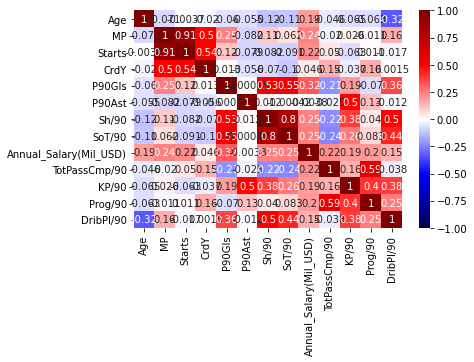

In [10]:
sns.heatmap(premleague.corr(), cmap='seismic', annot=True, vmin=-1, vmax=1)

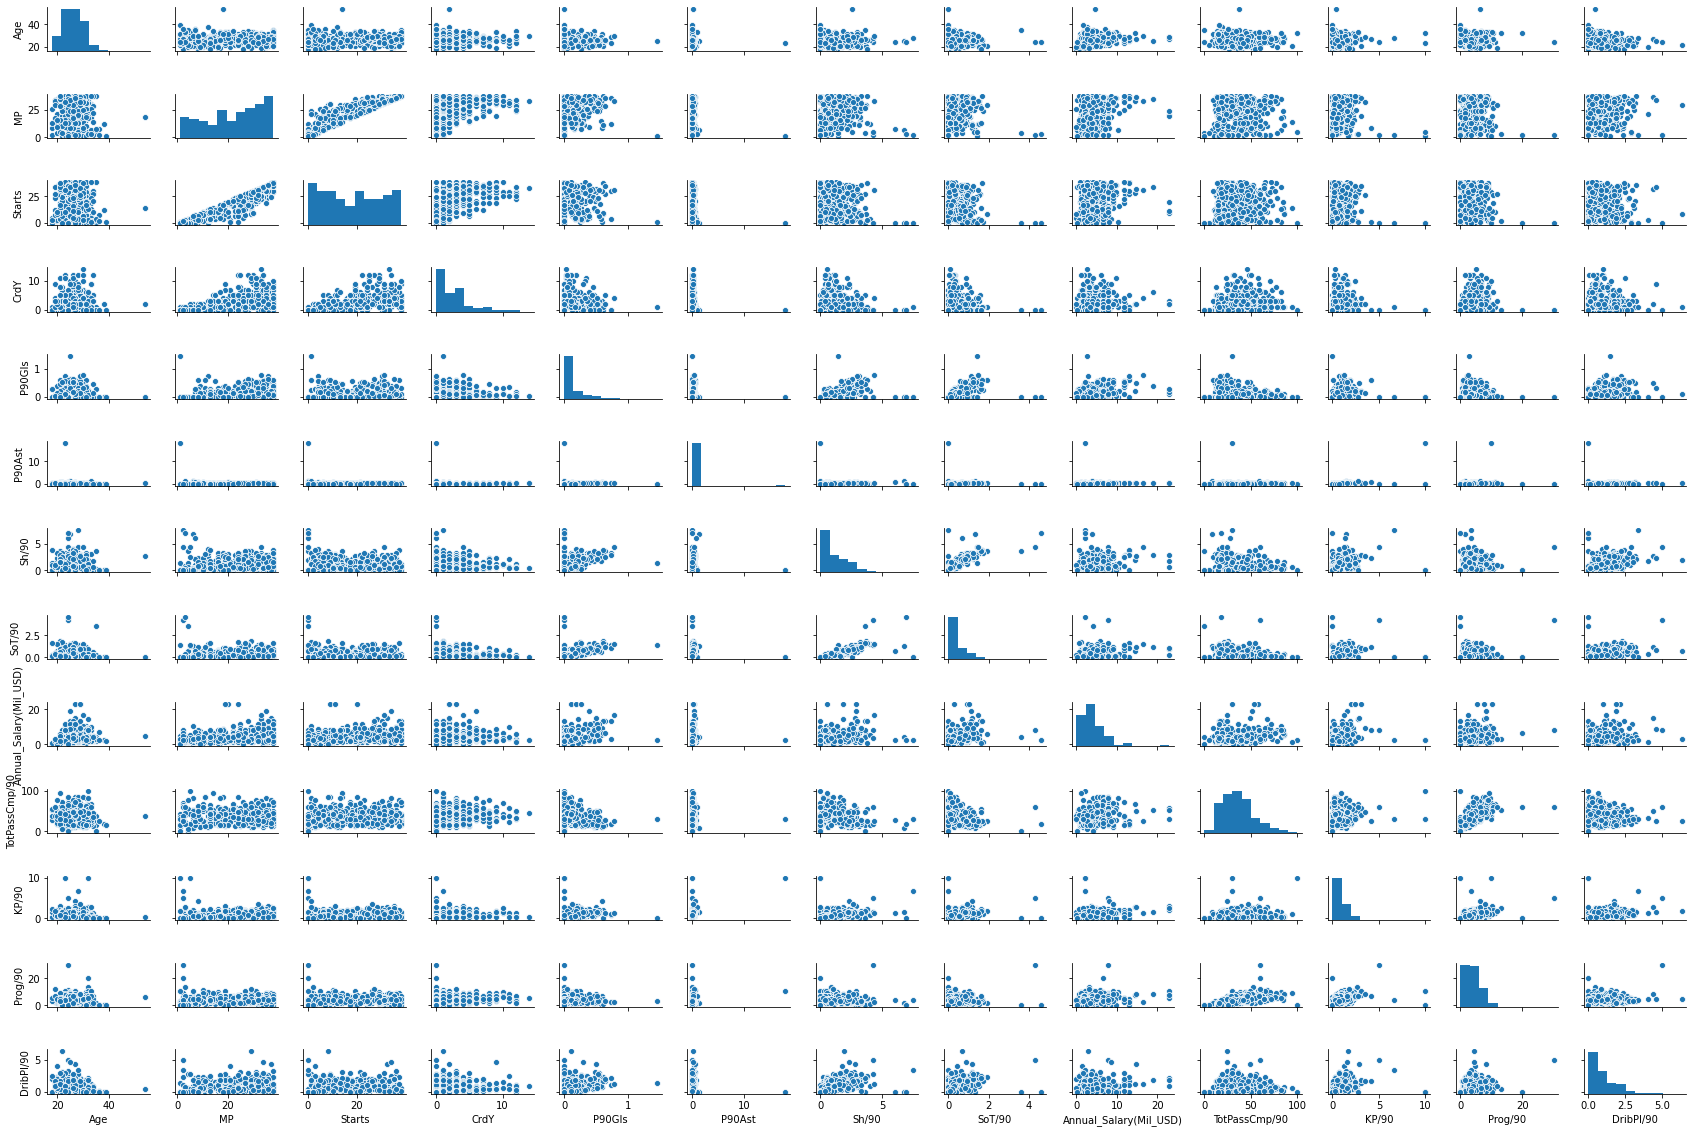

In [11]:
sns.pairplot(premleague, height=1.2, aspect=1.5)

# Modeling

## Baseline Model: Cross-Validation

In [12]:
X, y = premleague.drop('Annual_Salary(Mil_USD)',
                       axis=1), premleague['Annual_Salary(Mil_USD)']

In [13]:
def crossval(X, y):
    '''
    input: X(dataframe) of features, y(series) of target
    output: simple mean cross-validation, ridge mean cross-validation
    '''
    X, X_test, y, y_test = train_test_split(
        X, y, test_size=.2,
        random_state=10)  #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    X, y = np.array(X), np.array(y)

    #run the CV
    kf = KFold(n_splits=5, shuffle=True, random_state=71)
    cv_lm_r2s, cv_lm_reg_r2s = [], [
    ]  #collect the validation results for both models

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]

        #simple linear regression
        lm = LinearRegression()
        lm_reg = Ridge(alpha=0.17)

        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))

        #ridge with feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        lm_reg.fit(X_train_scaled, y_train)
        cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

    print('Simple regression scores: ', cv_lm_r2s)
    print('Ridge scores: ', cv_lm_reg_r2s, '\n')

    print(
        f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}'
    )
    print(
        f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}'
    )

In [14]:
crossval(X, y)

Simple regression scores:  [0.2923084262246486, 0.4234991962968456, 0.11744351288054022, -0.20105426065238108, -2.2979685696133805]
Ridge scores:  [0.2923849550802746, 0.42372858183789497, 0.11784676518783388, -0.19979001434729304, -2.286664557156015] 

Simple mean cv r^2: -0.333 +- 1.004
Ridge mean cv r^2: -0.330 +- 1.000


## Model Tuning

### Dropping Features

In [15]:
#dropping very lowly correlated features
X2, y2 = premleague.drop(['Annual_Salary(Mil_USD)', 'CrdY', 'P90Ast'],
                         axis=1), premleague['Annual_Salary(Mil_USD)']

In [16]:
crossval(X2, y2)

Simple regression scores:  [0.3554047744695348, 0.42300820740730716, 0.12808991586898333, -0.20256017677670046, 0.33109230927979527]
Ridge scores:  [0.3552889849398021, 0.4231882207940747, 0.1283474919818014, -0.20137132051922468, 0.3310629977888324] 

Simple mean cv r^2: 0.207 +- 0.227
Ridge mean cv r^2: 0.207 +- 0.227


In [17]:
#drop highly correlated features - MP
X3, y3 = premleague.drop(['Annual_Salary(Mil_USD)', 'CrdY', 'P90Ast', 'MP'],
                         axis=1), premleague['Annual_Salary(Mil_USD)']

In [18]:
crossval(X3, y3)

#resulted in better r^2 values

Simple regression scores:  [0.35800097320252366, 0.4296679719431623, 0.12849122745865427, -0.18737858933735763, 0.3342108044622819]
Ridge scores:  [0.35792509144282725, 0.4296065272615117, 0.12876225822824605, -0.18657206662740733, 0.3342110280428978] 

Simple mean cv r^2: 0.213 +- 0.224
Ridge mean cv r^2: 0.213 +- 0.223


### Log Transformation

In [19]:
from scipy import stats

In [20]:
def logtransform(columnlist):
    '''
    input: list of features
    output: new columns with log of feature
    '''
    for elem in columnlist:
        premleague[f'log{elem}'] = premleague[elem].apply(np.log1p) #log(x+1) due to zeros in features

    return premleague

**Sanity Reminder**<br/>
droping anyway: 'Annual_Salary(Mil_GBP)', 'CrdY', 'P90Ast', 'MP' <br/>
need log transform: p90goal, sh/90, sot/90, salary, KP/90, prog/90, dribpl/90

In [21]:
#log transforming right-skewed features
columns = [
    'P90Gls', 'Sh/90', 'SoT/90', 'Annual_Salary(Mil_USD)', 'KP/90', 'Prog/90',
    'DribPl/90'
]
premleague2 = logtransform(columns)

In [22]:
#run model on log transformed features
X4, y4 = premleague2.drop([
    'logAnnual_Salary(Mil_USD)', 'CrdY', 'P90Ast', 'MP', 'P90Gls', 'Sh/90',
    'SoT/90', 'Annual_Salary(Mil_USD)', 'KP/90', 'Prog/90', 'DribPl/90'
],
                          axis=1), premleague2['logAnnual_Salary(Mil_USD)']

In [23]:
crossval(X4, y4)

#new high score yay!

Simple regression scores:  [0.2963474865216501, 0.49404474476227556, 0.07089041878978952, 0.1462504615385537, 0.35398098306732406]
Ridge scores:  [0.2962504099547617, 0.4939391590805928, 0.07151236794803484, 0.1473612224241625, 0.3539976270061175] 

Simple mean cv r^2: 0.272 +- 0.150
Ridge mean cv r^2: 0.273 +- 0.150


### Comparing With and Without Log(Target)

In [24]:
#compare to just target
X5, y5 = premleague2.drop([
    'logAnnual_Salary(Mil_USD)', 'CrdY', 'P90Ast', 'MP', 'P90Gls', 'Sh/90',
    'SoT/90', 'Annual_Salary(Mil_USD)', 'KP/90', 'Prog/90', 'DribPl/90'
],
                          axis=1), premleague2['Annual_Salary(Mil_USD)']

In [25]:
crossval(X5, y5)

#resulted in lower r^2 values

Simple regression scores:  [0.36547357125489377, 0.47719986217863597, 0.18224939696599718, -0.17684128263608012, 0.3227665421996707]
Ridge scores:  [0.3653339330622861, 0.4772877276972082, 0.18241977112738572, -0.17535768408061192, 0.32275158011240146] 

Simple mean cv r^2: 0.234 +- 0.226
Ridge mean cv r^2: 0.234 +- 0.226


## Assumption Testing

### Residual Distribution

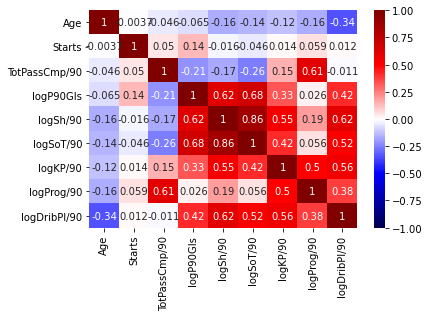

In [26]:
sns.heatmap(X4.corr(), cmap='seismic', annot=True, vmin=-1, vmax=1)

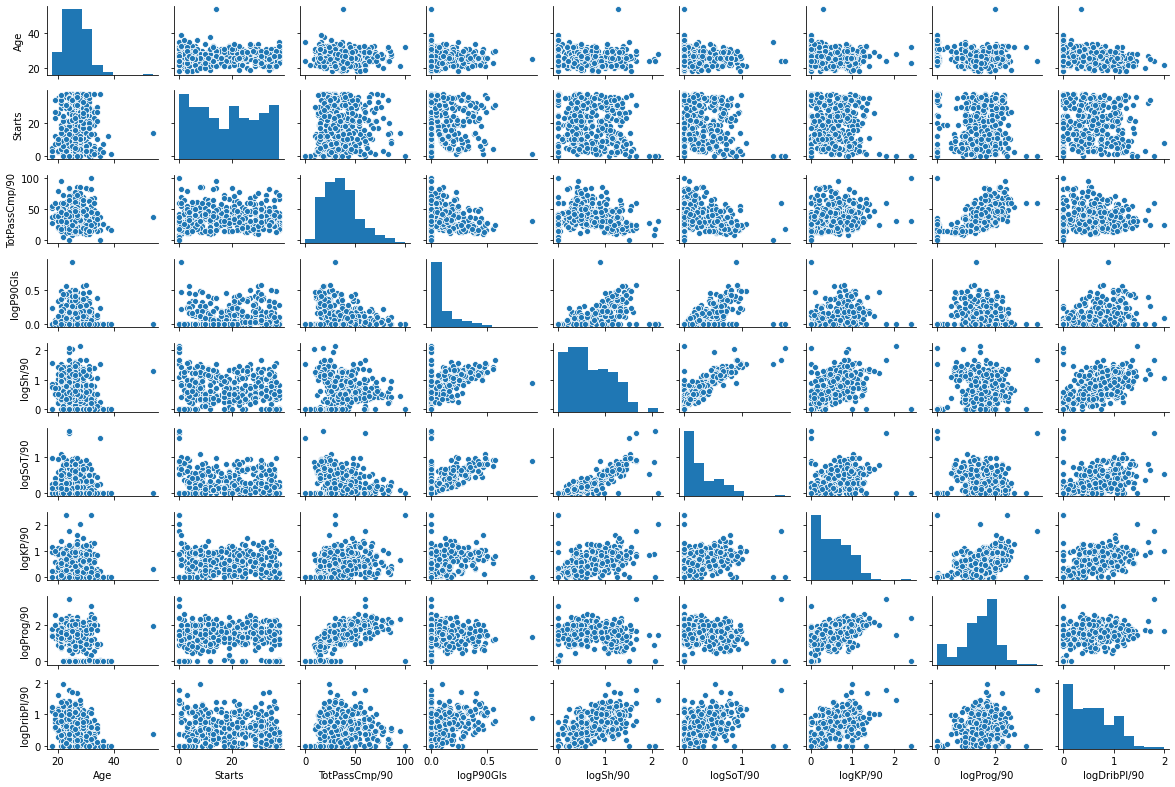

In [27]:
sns.pairplot(X4, height=1.2, aspect=1.5)

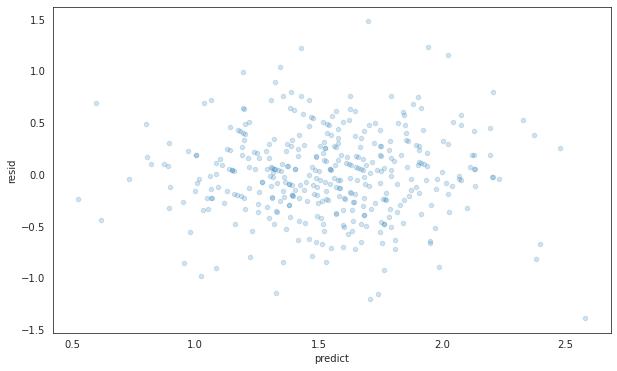

In [28]:
# develop OLS with Sklearn
lr = LinearRegression()
fit = lr.fit(X4, y4)  # for later use

# Plot your predicted values on the x-axis, and your residuals on the y-axis

premleague['predict'] = fit.predict(X4)
premleague[
    'resid'] = premleague['logAnnual_Salary(Mil_USD)'] - premleague.predict
with sns.axes_style('white'):
    plot = premleague.plot(kind='scatter',
                           x='predict',
                           y='resid',
                           alpha=0.2,
                           figsize=(10, 6))

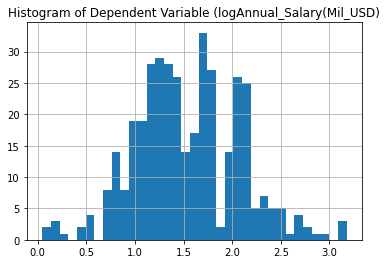

In [29]:
# inspect histogram
premleague['logAnnual_Salary(Mil_USD)'].hist(bins=35)
plt.title('Histogram of Dependent Variable (logAnnual_Salary(Mil_USD)')

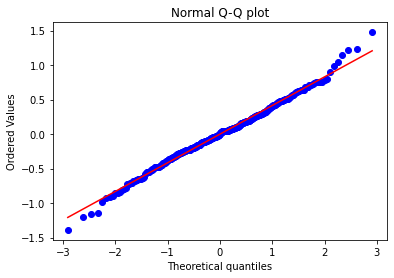

In [30]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(premleague['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Error Terms

In [31]:
model = sm.OLS(y4, X4)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     logAnnual_Salary(Mil_USD)   R-squared (uncentered):                   0.935
Model:                                   OLS   Adj. R-squared (uncentered):              0.933
Method:                        Least Squares   F-statistic:                              593.3
Date:                       Thu, 16 Jul 2020   Prob (F-statistic):                   2.43e-215
Time:                               16:15:09   Log-Likelihood:                         -208.68
No. Observations:                        383   AIC:                                      435.4
Df Residuals:                            374   BIC:                                      470.9
Df Model:                                  9                                                  
Covariance Type:                   nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Age               0.0315      0.002     13.549      0.000       0.027       0.036
Starts            0.0101      0.002      5.501      0.000       0.007       0.014
TotPassCmp/90     0.0130      0.002      7.637      0.000       0.010       0.016
logP90Gls         0.5938      0.222      2.675      0.008       0.157       1.030
logSh/90         -0.0313      0.105     -0.299      0.765      -0.237       0.174
logSoT/90         0.5381      0.163      3.300      0.001       0.217       0.859
logKP/90          0.1168      0.073      1.598      0.111      -0.027       0.260
logProg/90       -0.1474      0.053     -2.789      0.006      -0.251      -0.043
logDribPl/90      0.0152      0.071      0.213      0.831      -0.125       0.156
==============================================================================
Omnibus:                        6.573   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                9.862
Skew:                          -0.021   Prob(JB):                      0.00722
Kurtosis:                       3.785   Cond. No.                         558.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

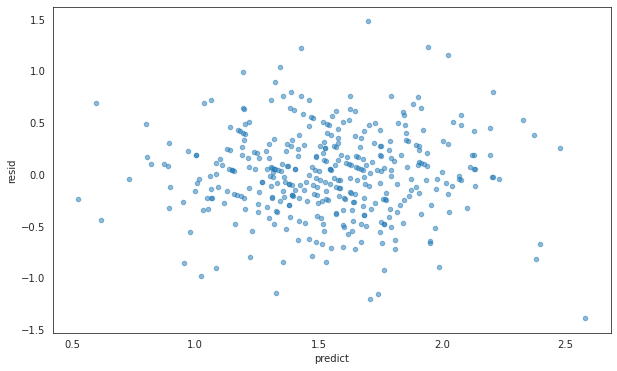

In [32]:
# create residual plot
with sns.axes_style('white'):
    plot = premleague.plot(kind='scatter',
                           x='predict',
                           y='resid',
                           alpha=0.5,
                           figsize=(10, 6))

## Model Testing

In [34]:
#selecting the best feature-target (X4, y4)
X4, X4_test, y4, y4_test = train_test_split(X4,
                                            y4,
                                            test_size=.2,
                                            random_state=10)

In [42]:
#fitting scaled X4, y4 to ridge regression
scaler = StandardScaler()
X4_scaled = scaler.fit_transform(X4)
X4_test_scaled = scaler.transform(X4_test)

ridge = Ridge(0.17)
ridge.fit(X4_scaled, y4)
print(f'Ridge Regression test R^2: {ridge.score(X4_test_scaled, y4_test):.3f}')

Ridge Regression test R^2: 0.520


# Interpreting Results

In [44]:
#scaled coef of features (X4)
ridge.coef_

array([ 0.16495739,  0.12816845,  0.22038413,  0.06453476,  0.01545071,
        0.17099992,  0.02014707, -0.0590056 ,  0.01134828])

In [50]:
#unscaled coef of features
unscaled_coef = np.true_divide(ridge.coef_, scaler.scale_)
unscaled_coef

array([ 0.0394345 ,  0.01074643,  0.01277966,  0.45691642,  0.03246085,
        0.56239688,  0.04754317, -0.09379899,  0.02704336])

In [46]:
#mean squared error (MSE)
y_true = y4_test
y_pred = ridge.predict(X4_test_scaled)

mean_squared_error(y_true, y_pred)

0.1396005178313938